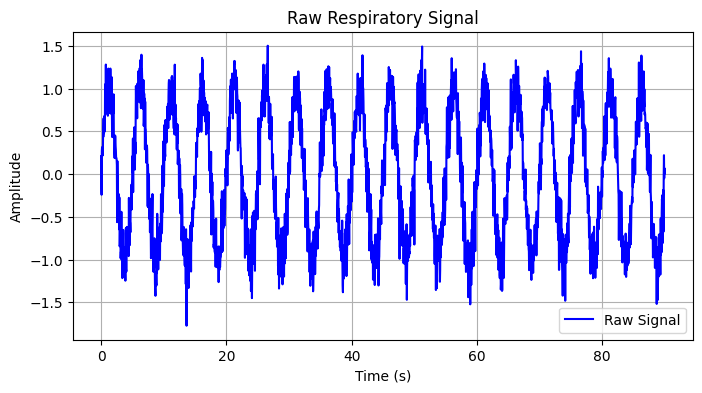

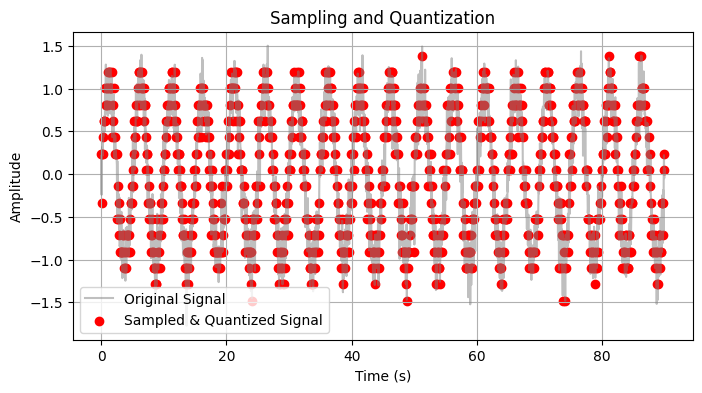

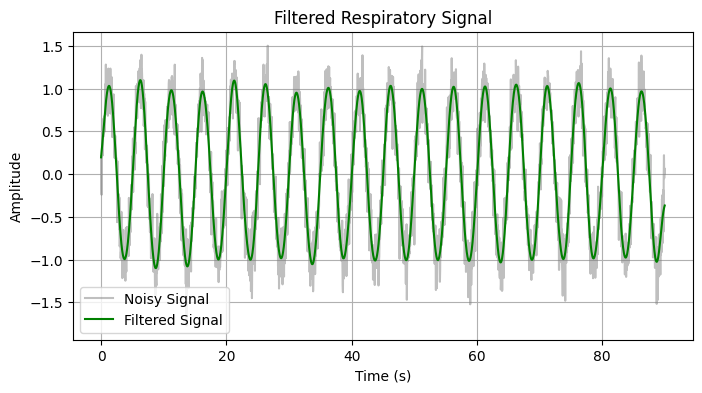

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Simulated or real respiratory signal (replace with actual data loading)
fs = 25  # Sampling frequency in Hz (as per the reference)
t = np.linspace(0, 90, fs * 90)  # Simulating 90 seconds of data
signal = np.sin(2 * np.pi * 0.2 * t) + 0.2 * np.random.randn(len(t))  # Simulated breathing wave

# Function to apply a low-pass filter (as per reference preprocessing)
def butter_lowpass_filter(data, cutoff=0.5, fs=25, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# **1. Plot Raw Respiratory Signal**
plt.figure(figsize=(8, 4))
plt.plot(t, signal, label="Raw Signal", color='blue')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw Respiratory Signal")
plt.legend()
plt.grid()
plt.show()

# **2. Sampling and Quantization**
sampling_rate = 10  # Sampling at lower rate (as per reference 25 Hz)
t_sampled = t[::fs // sampling_rate]
signal_sampled = signal[::fs // sampling_rate]

quant_levels = 16  # Simulated quantization levels
signal_quantized = np.round((signal_sampled - np.min(signal_sampled)) / 
                            (np.max(signal_sampled) - np.min(signal_sampled)) * 
                            (quant_levels - 1)) * ((np.max(signal_sampled) - np.min(signal_sampled)) / 
                            (quant_levels - 1)) + np.min(signal_sampled)

plt.figure(figsize=(8, 4))
plt.plot(t, signal, label="Original Signal", alpha=0.5, color='gray')
plt.scatter(t_sampled, signal_quantized, color='red', label="Sampled & Quantized Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Sampling and Quantization")
plt.legend()
plt.grid()
plt.show()

# **3. Filtering to Remove Noise**
filtered_signal = butter_lowpass_filter(signal)

plt.figure(figsize=(8, 4))
plt.plot(t, signal, alpha=0.5, label="Noisy Signal", color='gray')
plt.plot(t, filtered_signal, label="Filtered Signal", color='green')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Filtered Respiratory Signal")
plt.legend()
plt.grid()
plt.show()



Training LSTM model... Please wait...
Epoch 1/20
4/4 [==============================] - 3s 197ms/step - loss: 0.2184 - val_loss: 0.7030
Epoch 2/20
4/4 [==============================] - 0s 25ms/step - loss: 0.1903 - val_loss: 0.6365
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 0.1675 - val_loss: 0.5715
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 0.1416 - val_loss: 0.4928
Epoch 5/20
4/4 [==============================] - 0s 26ms/step - loss: 0.1113 - val_loss: 0.3877
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 0.0753 - val_loss: 0.2478
Epoch 7/20
4/4 [==============================] - 0s 28ms/step - loss: 0.0343 - val_loss: 0.0804
Epoch 8/20
4/4 [==============================] - 0s 26ms/step - loss: 0.0083 - val_loss: 0.0184
Epoch 9/20
4/4 [==============================] - 0s 25ms/step - loss: 0.0105 - val_loss: 0.3013
Epoch 10/20
4/4 [==============================] - 0s 25ms/step - loss: 0.0088 - val_lo

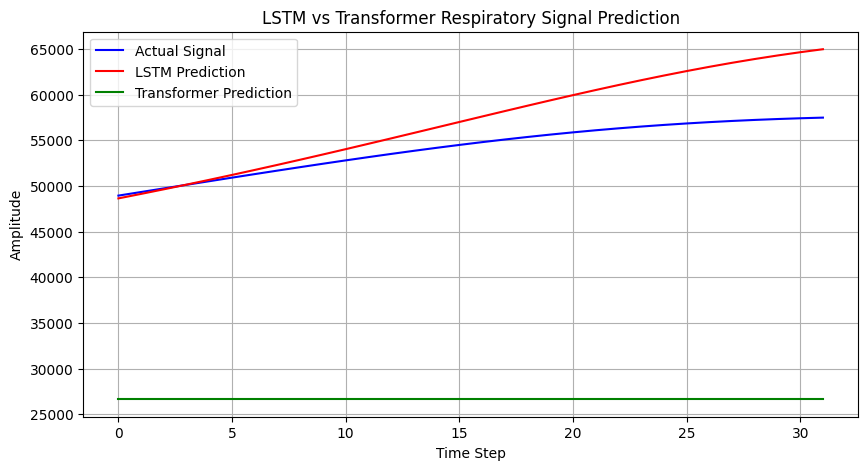

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, Add
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk, filedialog

# **1. Upload and Load Data**
def upload_file():
    root = Tk()
    root.withdraw()  # Hide Tkinter GUI
    file_path = filedialog.askopenfilename(title="Select Respiratory Signal CSV File")
    return file_path

file_path = upload_file()

if not file_path:
    print("No file selected. Exiting...")
    exit()

# **2. Load Data from CSV**
data = pd.read_csv(file_path)  # Ensure the CSV has a single column of respiratory signal values
signal = data.iloc[:, 0].values  # Extract first column
fs = 25  # Assumed sampling frequency

t = np.linspace(0, len(signal) / fs, len(signal))  # Create time axis

# **3. Apply Low-Pass Filtering**
def butter_lowpass_filter(data, cutoff=0.5, fs=25, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_signal = butter_lowpass_filter(signal)

# **4. Normalize Data for LSTM & Transformer**
scaler = MinMaxScaler(feature_range=(-1, 1))
filtered_signal_scaled = scaler.fit_transform(filtered_signal.reshape(-1, 1))

# **5. Create Sequences for Training**
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Use last 10-time steps to predict next one
X, y = create_sequences(filtered_signal_scaled, seq_length)

# **6. Split Data (80% Train, 20% Test)**
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# **7. Build LSTM Model**
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

print("\nTraining LSTM model... Please wait...")
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# **8. Build Transformer Model**
def transformer_block(inputs, num_heads=4, ff_dim=32, dropout_rate=0.1):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    norm1 = LayerNormalization(epsilon=1e-6)(Add()([inputs, attention]))
    dropout1 = Dropout(dropout_rate)(norm1)
    
    ff_output = Dense(ff_dim, activation="relu")(dropout1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    norm2 = LayerNormalization(epsilon=1e-6)(Add()([dropout1, ff_output]))
    return Dropout(dropout_rate)(norm2)

input_layer = Input(shape=(seq_length, 1))
transformer = transformer_block(input_layer)
transformer = transformer_block(transformer)
transformer = Dense(1)(transformer[:, -1, :])  # Predict next time step

transformer_model = Model(inputs=input_layer, outputs=transformer)
transformer_model.compile(optimizer="adam", loss="mse")

print("\nTraining Transformer model... Please wait...")
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# **9. Make Predictions**
y_pred_lstm = lstm_model.predict(X_test)
y_pred_transformer = transformer_model.predict(X_test)

# Convert back to original scale
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm)
y_pred_transformer_original = scaler.inverse_transform(y_pred_transformer)
y_test_original = scaler.inverse_transform(y_test)

# **10. Plot Results**
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label="Actual Signal", color='blue')
plt.plot(y_pred_lstm_original, label="LSTM Prediction", color='red')
plt.plot(y_pred_transformer_original, label="Transformer Prediction", color='green')
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.title("LSTM vs Transformer Respiratory Signal Prediction")
plt.legend()
plt.grid()
plt.show()



Training LSTM model... Please wait...
Epoch 1/20
56/56 [==============================] - 4s 22ms/step - loss: 0.1337 - val_loss: 0.0279
Epoch 2/20
56/56 [==============================] - 1s 13ms/step - loss: 0.0214 - val_loss: 0.0159
Epoch 3/20
56/56 [==============================] - 1s 12ms/step - loss: 0.0081 - val_loss: 0.0011
Epoch 4/20
56/56 [==============================] - 1s 12ms/step - loss: 7.0005e-04 - val_loss: 4.7001e-04
Epoch 5/20
56/56 [==============================] - 1s 11ms/step - loss: 3.0018e-04 - val_loss: 1.7478e-04
Epoch 6/20
56/56 [==============================] - 1s 12ms/step - loss: 2.0518e-04 - val_loss: 3.8767e-04
Epoch 7/20
56/56 [==============================] - 1s 12ms/step - loss: 1.3504e-04 - val_loss: 3.1971e-04
Epoch 8/20
56/56 [==============================] - 1s 12ms/step - loss: 9.9711e-05 - val_loss: 7.8526e-05
Epoch 9/20
56/56 [==============================] - 1s 12ms/step - loss: 8.6844e-05 - val_loss: 2.1649e-04
Epoch 10/20
56/56 [===

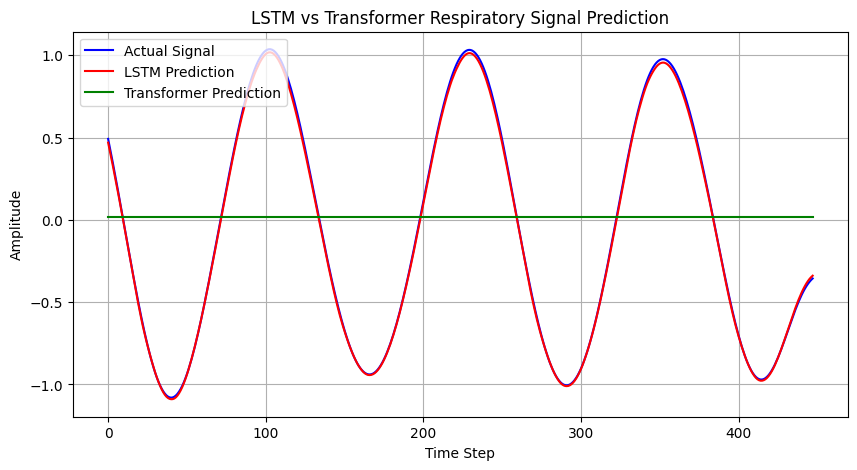

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, Add
from sklearn.preprocessing import MinMaxScaler

# Simulated respiratory signal (Replace with real data)
fs = 25  # Sampling frequency in Hz
t = np.linspace(0, 90, fs * 90)  # Simulating 90 seconds of data
signal = np.sin(2 * np.pi * 0.2 * t) + 0.2 * np.random.randn(len(t))  # Simulated breathing wave

# Function to apply a low-pass filter
def butter_lowpass_filter(data, cutoff=0.5, fs=25, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply filtering
filtered_signal = butter_lowpass_filter(signal)

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
filtered_signal_scaled = scaler.fit_transform(filtered_signal.reshape(-1, 1))

# Create sequences for training
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Use the last 10 time steps to predict the next one
X, y = create_sequences(filtered_signal_scaled, seq_length)

# Split data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# **LSTM Model**
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

print("\nTraining LSTM model... Please wait...")
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# **Transformer Model**
def transformer_block(inputs, num_heads=4, ff_dim=32, dropout_rate=0.1):
    """Transformer block with Multi-Head Attention, Layer Normalization, and Feed-Forward Network"""
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    norm1 = LayerNormalization(epsilon=1e-6)(Add()([inputs, attention]))
    dropout1 = Dropout(dropout_rate)(norm1)
    
    ff_output = Dense(ff_dim, activation="relu")(dropout1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    norm2 = LayerNormalization(epsilon=1e-6)(Add()([dropout1, ff_output]))
    return Dropout(dropout_rate)(norm2)

# Define Transformer model
input_layer = Input(shape=(seq_length, 1))
transformer = transformer_block(input_layer)
transformer = transformer_block(transformer)
transformer = Dense(1)(transformer[:, -1, :])  # Predict next time step

transformer_model = Model(inputs=input_layer, outputs=transformer)
transformer_model.compile(optimizer="adam", loss="mse")

print("\nTraining Transformer model... Please wait...")
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# **Make Predictions**
y_pred_lstm = lstm_model.predict(X_test)
y_pred_transformer = transformer_model.predict(X_test)

# Convert back to original scale
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm)
y_pred_transformer_original = scaler.inverse_transform(y_pred_transformer)
y_test_original = scaler.inverse_transform(y_test)

# **Plot Predictions**
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label="Actual Signal", color='blue')
plt.plot(y_pred_lstm_original, label="LSTM Prediction", color='red')
plt.plot(y_pred_transformer_original, label="Transformer Prediction", color='green')
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.title("LSTM vs Transformer Respiratory Signal Prediction")
plt.legend()
plt.grid()
plt.show()


In [6]:
pip install numpy scipy matplotlib peakutils


Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install peakutils

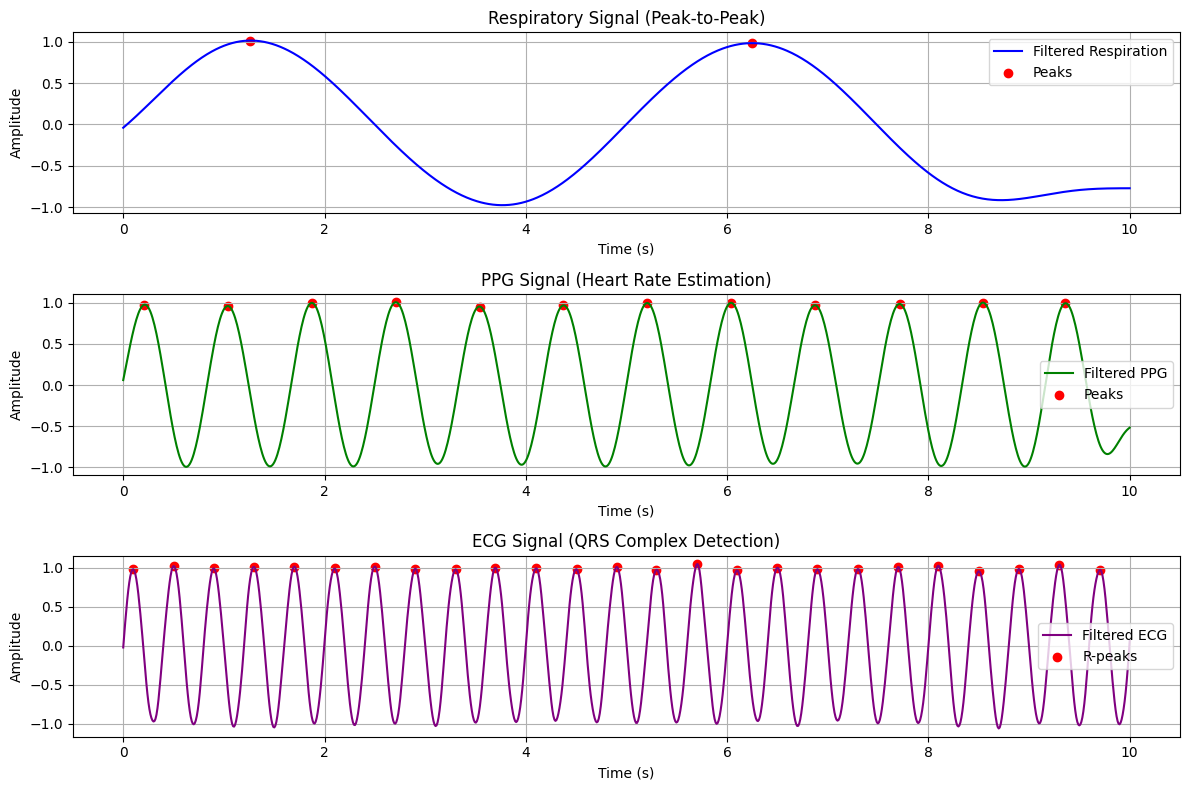

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import peakutils  # For better peak detection

# **1. Simulated or Real Data Loading (Replace with actual data)**
fs = 100  # Higher sampling frequency for ECG/PPG (100Hz)
t = np.linspace(0, 10, fs * 10)  # Simulating 10 seconds of data

# **Synthetic Signals (Replace with real signals if available)**
respiration_signal = np.sin(2 * np.pi * 0.2 * t) + 0.2 * np.random.randn(len(t))  # Respiratory
ppg_signal = np.sin(2 * np.pi * 1.2 * t) + 0.1 * np.random.randn(len(t))  # Simulated PPG
ecg_signal = np.sin(2 * np.pi * 2.5 * t) + 0.05 * np.random.randn(len(t))  # Simulated ECG

# **2. Filtering Functions**
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# **Apply Filtering**
filtered_respiration = butter_lowpass_filter(respiration_signal, cutoff=0.5, fs=fs)
filtered_ppg = butter_lowpass_filter(ppg_signal, cutoff=2, fs=fs)
filtered_ecg = butter_lowpass_filter(ecg_signal, cutoff=10, fs=fs)

# **3. Extract Peak-to-Peak Values**
respiration_peaks, _ = find_peaks(filtered_respiration, distance=fs//2)  # Respiration peaks
ppg_peaks, _ = find_peaks(filtered_ppg, distance=fs//3)  # PPG peaks
ecg_peaks, _ = find_peaks(filtered_ecg, distance=fs//5)  # ECG peaks

# **4. Plot the Extracted Signals with Peaks**
plt.figure(figsize=(12, 8))

# **Respiration Signal**
plt.subplot(3, 1, 1)
plt.plot(t, filtered_respiration, label="Filtered Respiration", color='blue')
plt.scatter(t[respiration_peaks], filtered_respiration[respiration_peaks], color='red', label="Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Respiratory Signal (Peak-to-Peak)")
plt.legend()
plt.grid()

# **PPG Signal**
plt.subplot(3, 1, 2)
plt.plot(t, filtered_ppg, label="Filtered PPG", color='green')
plt.scatter(t[ppg_peaks], filtered_ppg[ppg_peaks], color='red', label="Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("PPG Signal (Heart Rate Estimation)")
plt.legend()
plt.grid()

# **ECG Signal**
plt.subplot(3, 1, 3)
plt.plot(t, filtered_ecg, label="Filtered ECG", color='purple')
plt.scatter(t[ecg_peaks], filtered_ecg[ecg_peaks], color='red', label="R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG Signal (QRS Complex Detection)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
